# Introduction - Sell in May and Go Away ?  

This notebook captures 10 years of daily historical data from ST Louis Federal Reserve's database for the following 5 securities:  

- S&P 500  
- 10 Year Treaury Bond  
- Gold  
- Oil  
- Bitcoin  

The goal is to answer several questions that could help various firms in the financial industry capitalize on patterns in market data.  Another goal is to explain relationships among various securities and provide a better understanding of day to day movements in price.  Accurately predicting daily price change can be profitable for short term trading while predicting medium or long term price change can be very beneficial for wide ranging planning and stretegic purposes for many, many different businesses and industries.  Specifically, this notebook addresses the following questions:  

-  Do the different days of the week have a different rate of return (for the above mentioned securities) over the past 10 years ?  
-  Does the daily weather have an affect on daily price change ?
-  Do the different months of the year have a significant difference in rate of return over time ?
-  Is the rate of return for the months of November to May better than the other 6 months ?
-  Are there any unexpected or unspecified relationships between the 5 securities that could yield competitive advantages.  

This notebook will follow the outline:  

1.  Weather Data  
2.  Financial Data  
3.  Weather and Financial Data Combined  
    A.  Supervised Predictive Models  
    B.  Unsupbervised Predictive Models  


Import necessary modules and libraries.

In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy import stats
import sklearn
from sklearn import preprocessing
from sklearn import linear_model
import seaborn as sns
%matplotlib inline

# 1.  Weather Data  

Import weather data for New York City from meteoblue.com.

In [2]:
# Use pandas read_csv command to import the local csv file
dfw = pd.read_csv('nyc_daily.csv', skiprows=11, sep=';')
dft = pd.read_csv('temp_and_snow.csv', skiprows=11, sep=';')
dfw.head()

,Year,Month,Day,Hour,Minute,Sunshine Duration daily sum [sfc]
0,2009,6,25,0,0,-726.93
1,2009,6,26,0,0,418.70
2,2009,6,27,0,0,743.23
3,2009,6,28,0,0,436.08
4,2009,6,29,0,0,848.28


In [3]:
dft.head()

,Year,Month,Day,Hour,Minute,Temperature daily mean [2 m above gnd],Snowfall Amount (high resolution) daily sum [sfc],Temperature daily max [2 m above gnd],Temperature daily min [2 m above gnd]
0,2009,6,25,0,0,71.72,0.0,81.24,64.02
1,2009,6,26,0,0,76.91,0.0,88.19,66.18
2,2009,6,27,0,0,76.34,0.0,83.91,65.85
3,2009,6,28,0,0,72.35,0.0,78.78,66.54
4,2009,6,29,0,0,75.43,0.0,84.19,65.20


Drop some of the data not needed for now; rename a column and drop the first (and strange) negative number.

In [4]:
# drop the Hour and Minute columns
dfw.drop(['Hour', 'Minute'], axis=1, inplace=True)
dft.drop(['Hour', 'Minute'], axis=1, inplace=True)

# change long named column to just 'Sun'
dfw.columns = ['Year', 'Month', 'Day', 'Sun']
dft.columns = ['Year', 'Month', 'Day', 'avg_temp', 'snow', 'max', 'min']

# Convert negative numbers to zero
dfw[dfw < 0] = 0
dft[dft < 0] = 0

# drop 'snow', 'max', 'min' for now
dft.drop(['snow', 'max', 'min'], axis=1, inplace=True)

print(dfw.columns)
print(dft.columns)

Index(['Year', 'Month', 'Day', 'Sun'], dtype='object')
Index(['Year', 'Month', 'Day', 'avg_temp'], dtype='object')


Next, look at the first five lines of the dataframe.

In [5]:
dfw.head()

,Year,Month,Day,Sun
0,2009,6,25,0.00
1,2009,6,26,418.70
2,2009,6,27,743.23
3,2009,6,28,436.08
4,2009,6,29,848.28


Set up the data to plot the number of minutes of sun per day over the entire time horizon.

In [6]:
dfw_plot = dfw
dfw_plot['dt'] = pd.to_datetime((dfw.Year*10000+dfw.Month*100+dfw.Day).apply(str),format='%Y%m%d')
dfw_plot.columns = ['Year', 'Month', 'Day', 'Sun', 'dt']
dfw_plot.index = pd.to_datetime(dfw_plot.dt)
dfw_plot.drop(['Year'], axis=1, inplace=True)
dfw_plot.drop(['Month'], axis=1, inplace=True)
dfw_plot.drop(['Day'], axis=1, inplace=True)
dfw_plot.drop(['dt'], axis=1, inplace=True)

dft['dt'] = pd.to_datetime((dft.Year*10000+dft.Month*100+dft.Day).apply(str),format='%Y%m%d')
dft.columns = ['Year', 'Month', 'Day', 'avg_temp', 'dt']
dft.index = pd.to_datetime(dft.dt)
dft.drop(['Year'], axis=1, inplace=True)
dft.drop(['Month'], axis=1, inplace=True)
dft.drop(['Day'], axis=1, inplace=True)
dft.drop(['dt'], axis=1, inplace=True)

In [7]:
dfw_plot.dtypes

Sun    float64
dtype: object

In [8]:
dfw_plot.head()

,Sun
dt,
2009-06-25,0.00
2009-06-26,418.70
2009-06-27,743.23
2009-06-28,436.08
2009-06-29,848.28


In the above dataframe, the index has been changed to a date-time object.  Next, the plot shows the amount of sunshine in minutes for New York City.

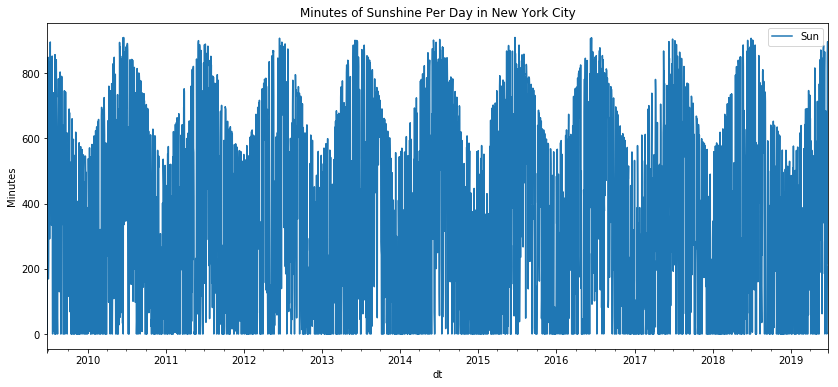

In [9]:
dfw_plot.plot(figsize=(14, 6))
plt.title('Minutes of Sunshine Per Day in New York City')
plt.ylabel('Minutes')
plt.show()

The seasonality is obvious from the plot above.  Many more minutes of sunshine in the summer months than in the winter.  Does this have any affect on trading activity or price change in the equtiy markets ?  New York City was chosen because it is a financial hub, wall street is there, the largest banks and hedge funds are there, and it's a generally a massively influencial city in the world of Finance.  

This next line of code groups the number of sunny hours by day of the month.  This was originally created because the data was listed and imported by the hour.  However, the data used in this study is grouped by day.

# Financial Data

In [10]:
df = pd.read_csv('SP500.csv')
df_10 = pd.read_csv('DGS10.csv')
df_10_10 = pd.read_csv('DGS10_10.csv')
df_gold = pd.read_csv('gold.csv')
df_oil = pd.read_csv('oil.csv')
df_btc = pd.read_csv('btc.csv')


# Convert price to a number, with coersion to throw NA's if conversion not possible
df['price'] = pd.to_numeric(df.SP500, errors='coerce')
df_10['price'] = pd.to_numeric(df_10.DGS10, errors='coerce')
df_10_10['price'] = pd.to_numeric(df_10_10.DGS10, errors='coerce')
df_gold['price'] = pd.to_numeric(df_gold.GOLDAMGBD229NLBM, errors='coerce')
df_oil['price'] = pd.to_numeric(df_oil.DCOILWTICO, errors='coerce')
df_btc['price'] = pd.to_numeric(df_btc.CBBTCUSD, errors='coerce')


# Remove NA's
df.dropna(inplace=True)
df_10.dropna(inplace=True)
df_10_10.dropna(inplace=True)
df_gold.dropna(inplace=True)
df_oil.dropna(inplace=True)
df_btc.dropna(inplace=True)

In [11]:
df.head()

,DATE,SP500,price
0,2009-06-26,918.90,918.90
1,2009-06-29,927.23,927.23
2,2009-06-30,919.32,919.32
3,2009-07-01,923.33,923.33
4,2009-07-02,896.42,896.42


In [12]:
df_10.head()

,DATE,DGS10,price
0,1962-01-02,4.06,4.06
1,1962-01-03,4.03,4.03
2,1962-01-04,3.99,3.99
3,1962-01-05,4.02,4.02
4,1962-01-08,4.03,4.03


In [13]:
df_10_10.head()

,DATE,DGS10,price
0,2009-06-26,3.52,3.52
1,2009-06-29,3.51,3.51
2,2009-06-30,3.53,3.53
3,2009-07-01,3.55,3.55
4,2009-07-02,3.51,3.51


In [14]:
df_gold.head()

,DATE,GOLDAMGBD229NLBM,price
0,2009-06-26,572.566,572.566
1,2009-06-29,570.133,570.133
2,2009-06-30,566.697,566.697
3,2009-07-01,567.296,567.296
4,2009-07-02,571.708,571.708


In [15]:
print(df_gold.columns)
print(df_gold.dtypes)

Index(['DATE', 'GOLDAMGBD229NLBM', 'price'], dtype='object')
DATE                 object
GOLDAMGBD229NLBM     object
price               float64
dtype: object


In [16]:
df_btc.head()

,DATE,CBBTCUSD,price
0,2014-12-01,370,370.0
1,2014-12-02,378,378.0
2,2014-12-03,378,378.0
3,2014-12-04,377.1,377.1
5,2014-12-06,378,378.0


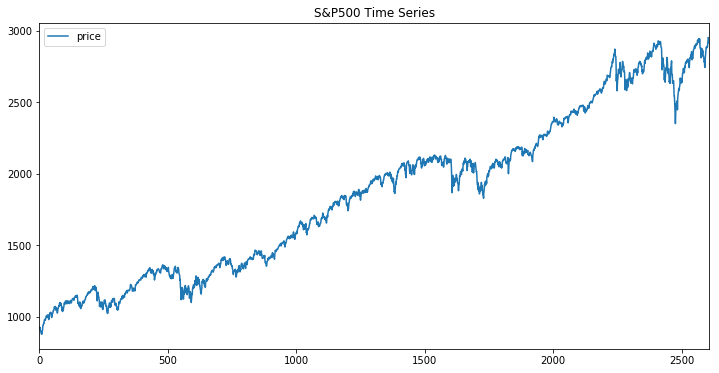

In [17]:
df.plot(figsize=(12, 6))
plt.title('S&P500 Time Series')
plt.show()

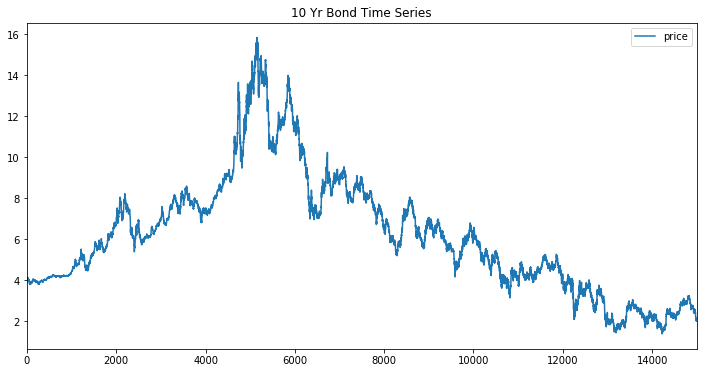

In [18]:
df_10.plot(figsize=(12, 6))
plt.title('10 Yr Bond Time Series')
plt.show()

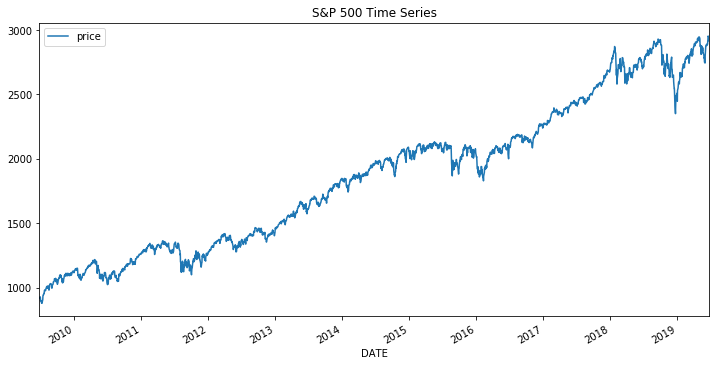

In [19]:
df.index = pd.to_datetime(df.DATE)
df.plot(figsize=(12, 6))
plt.title('S&P 500 Time Series')
plt.show()

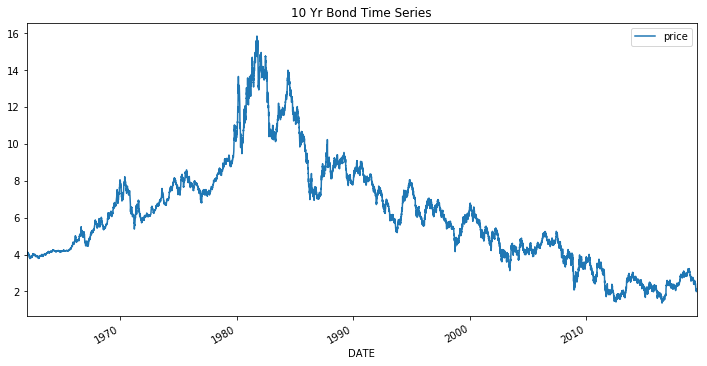

In [20]:
df_10.index = pd.to_datetime(df_10.DATE)
df_10.plot(figsize=(12, 6))
plt.title('10 Yr Bond Time Series')
plt.show()

In [21]:
print(df.dtypes)
print(df_10.dtypes)

DATE      object
SP500     object
price    float64
dtype: object
DATE      object
DGS10     object
price    float64
dtype: object


The next step separates the weekday, day of month, month and year from the date object.

In [22]:
# For S&P 500
df['date_time'] = pd.to_datetime(df['DATE'])

df['weekday'] = df.date_time.dt.weekday
df['day'] = df.date_time.dt.day
df['month'] = df.date_time.dt.month
df['year'] = df.date_time.dt.year

# For 10 Yr Bond
df_10['date_time'] = pd.to_datetime(df_10['DATE'])

df_10['weekday'] = df_10.date_time.dt.weekday
df_10['day'] = df_10.date_time.dt.day
df_10['month'] = df_10.date_time.dt.month
df_10['year'] = df_10.date_time.dt.year

# For 10 Yr Bond (last 10 years only)
df_10_10['date_time'] = pd.to_datetime(df_10_10['DATE'])

df_10_10['weekday'] = df_10_10.date_time.dt.weekday
df_10_10['day'] = df_10_10.date_time.dt.day
df_10_10['month'] = df_10_10.date_time.dt.month
df_10_10['year'] = df_10_10.date_time.dt.year

# For gold (last 10 years only)
df_gold['date_time'] = pd.to_datetime(df_gold['DATE'])

df_gold['weekday'] = df_gold.date_time.dt.weekday
df_gold['day'] = df_gold.date_time.dt.day
df_gold['month'] = df_gold.date_time.dt.month
df_gold['year'] = df_gold.date_time.dt.year

# For oil (last 10 years only)
df_oil['date_time'] = pd.to_datetime(df_oil['DATE'])

df_oil['weekday'] = df_oil.date_time.dt.weekday
df_oil['day'] = df_oil.date_time.dt.day
df_oil['month'] = df_oil.date_time.dt.month
df_oil['year'] = df_oil.date_time.dt.year

# For bitcoin
df_btc['date_time'] = pd.to_datetime(df_btc['DATE'])

df_btc['weekday'] = df_btc.date_time.dt.weekday
df_btc['day'] = df_btc.date_time.dt.day
df_btc['month'] = df_btc.date_time.dt.month
df_btc['year'] = df_btc.date_time.dt.year

0 = Monday  
1 = Tuesday  
2 = Wednesday  
3 = Thursday  
4 = Friday  

Prices are the closing price for the day listed.

In [23]:
df.tail()

,DATE,SP500,price,date_time,weekday,day,month,year
DATE,,,,,,,,
2019-06-19,2019-06-19,2926.46,2926.46,2019-06-19,2,19,6,2019
2019-06-20,2019-06-20,2954.18,2954.18,2019-06-20,3,20,6,2019
2019-06-21,2019-06-21,2950.46,2950.46,2019-06-21,4,21,6,2019
2019-06-24,2019-06-24,2945.35,2945.35,2019-06-24,0,24,6,2019
2019-06-25,2019-06-25,2917.38,2917.38,2019-06-25,1,25,6,2019


In [24]:
df_10.tail()

,DATE,DGS10,price,date_time,weekday,day,month,year
DATE,,,,,,,,
2019-06-19,2019-06-19,2.03,2.03,2019-06-19,2,19,6,2019
2019-06-20,2019-06-20,2.01,2.01,2019-06-20,3,20,6,2019
2019-06-21,2019-06-21,2.07,2.07,2019-06-21,4,21,6,2019
2019-06-24,2019-06-24,2.02,2.02,2019-06-24,0,24,6,2019
2019-06-25,2019-06-25,2.00,2.00,2019-06-25,1,25,6,2019


This next step creates a new column in the dataframe that represents the change in price per day.

In [25]:
# add a column for the change in price each day
df['change'] = df.price - df.price.shift()
df_10['change'] = df_10.price - df_10.price.shift()
df_10_10['change'] = df_10_10.price - df_10_10.price.shift()
df_gold['change'] = df_gold.price - df_gold.price.shift()
df_oil['change'] = df_oil.price - df_oil.price.shift()
df_btc['change'] = df_btc.price - df_btc.price.shift()

In [26]:
df.tail()

,DATE,SP500,price,date_time,weekday,day,month,year,change
DATE,,,,,,,,,
2019-06-19,2019-06-19,2926.46,2926.46,2019-06-19,2,19,6,2019,8.71
2019-06-20,2019-06-20,2954.18,2954.18,2019-06-20,3,20,6,2019,27.72
2019-06-21,2019-06-21,2950.46,2950.46,2019-06-21,4,21,6,2019,-3.72
2019-06-24,2019-06-24,2945.35,2945.35,2019-06-24,0,24,6,2019,-5.11
2019-06-25,2019-06-25,2917.38,2917.38,2019-06-25,1,25,6,2019,-27.97


Print the overall mean of the price change per day over the 10 year period for the S&P 500.

In [27]:
# print mean of 'change' column
print(df.change.mean())

0.7946242544731611


Next, group by month to see if any of the months are significantly stronger than any other.

In [28]:
df_month = df.groupby('month').sum()
df_month.head(20)

,price,weekday,day,year,change
month,,,,,
1,378230.08,426,3338,406938,268.09
2,361761.37,402,2767,386783,375.10
3,417535.75,435,3448,439151,240.67
4,402318.47,397,3221,417001,247.74
5,416424.88,446,3294,429099,-185.89
6,408419.00,425,3315,429052,128.84
7,375239.75,424,3499,424842,438.02
8,397742.10,442,3557,447006,-93.05
9,364306.26,430,3282,410745,97.79


Looks like May has the weakest return over the past 10 years and July has the strongest.  Is this difference significant or is it just due to random chance ?  If the total return is added for months November to the end of April, the price gain is about **1407**.  This compares to a price gain of just **592** for the months of May through October over the entire 10 year horizon.  It looks like buying the index in early November and selling in early May might be a good strategy.  However, there is a gain for the "summer" months (May - October), so why not just buy and hold all year round ?  Well, the past 10 years has been the longest running bull market in history and 10 years happens to be the total time frame for this study.  More data is needed to examine this concept more robustly.  

The next grouping just looks at yearly data for the S&P 500.

In [29]:
# group S&P 500 data by year to see the differences
df_year = df.groupby('year').sum()

In [30]:
df_year.head(12)

,price,weekday,day,month,change
year,,,,,
2009,136171.63,259,2119,1233,196.20
2010,287271.34,509,3950,1659,142.54
2011,319444.96,513,3940,1650,-0.04
2012,344838.35,509,3944,1625,168.59
2013,414237.34,508,3944,1649,422.17
2014,486706.78,506,3972,1651,210.54
2015,519389.07,505,3969,1655,-14.96
2016,527852.13,513,3952,1652,194.89
2017,614718.17,512,3966,1640,434.78


The above grouping for each year was to look at the possible differences in daily returns for the S&P 500 and to see if perhaps the 3rd Presidential Year (years 2011, 2015, 2019).  However, the summer and winter data for each year cannot be compared with the above grouping because the winter months span over 2 calendar years.  

Next, the grouping shows gold data by month to see if a particular month of the year is significantly stronger than the others.

In [31]:
df_gold.head()

,DATE,GOLDAMGBD229NLBM,price,date_time,weekday,day,month,year,change
0,2009-06-26,572.566,572.566,2009-06-26,4,26,6,2009,NaN
1,2009-06-29,570.133,570.133,2009-06-29,0,29,6,2009,-2.433
2,2009-06-30,566.697,566.697,2009-06-30,1,30,6,2009,-3.436
3,2009-07-01,567.296,567.296,2009-07-01,2,1,7,2009,0.599
4,2009-07-02,571.708,571.708,2009-07-02,3,2,7,2009,4.412


In [32]:
df_month_gold = df_gold.groupby('month').sum()
df_month_gold.head(12)

,price,weekday,day,year,change
month,,,,,
1,189278.695,426,3516,425072,199.865
2,183668.729,402,2946,406928,224.082
3,197939.557,435,3420,437135,-110.305
4,177724.763,393,3084,396861,-74.310
5,184411.585,446,3279,410966,51.605
6,190034.889,424,3306,425028,27.311
7,189138.751,444,3538,444977,45.390
8,186008.333,441,3259,424854,316.562
9,189927.498,430,3325,430880,-101.386


The above grouping shows August as the strongest month and a lot higher than March - the weakest - but, this could be due to random chance.  A significance test is needed.

In [33]:
df.head()

,DATE,SP500,price,date_time,weekday,day,month,year,change
DATE,,,,,,,,,
2009-06-26,2009-06-26,918.90,918.90,2009-06-26,4,26,6,2009,NaN
2009-06-29,2009-06-29,927.23,927.23,2009-06-29,0,29,6,2009,8.33
2009-06-30,2009-06-30,919.32,919.32,2009-06-30,1,30,6,2009,-7.91
2009-07-01,2009-07-01,923.33,923.33,2009-07-01,2,1,7,2009,4.01
2009-07-02,2009-07-02,896.42,896.42,2009-07-02,3,2,7,2009,-26.91


In [34]:
df.dtypes

DATE                 object
SP500                object
price               float64
date_time    datetime64[ns]
weekday               int64
day                   int64
month                 int64
year                  int64
change              float64
dtype: object

In [35]:
df.head()

,DATE,SP500,price,date_time,weekday,day,month,year,change
DATE,,,,,,,,,
2009-06-26,2009-06-26,918.90,918.90,2009-06-26,4,26,6,2009,NaN
2009-06-29,2009-06-29,927.23,927.23,2009-06-29,0,29,6,2009,8.33
2009-06-30,2009-06-30,919.32,919.32,2009-06-30,1,30,6,2009,-7.91
2009-07-01,2009-07-01,923.33,923.33,2009-07-01,2,1,7,2009,4.01
2009-07-02,2009-07-02,896.42,896.42,2009-07-02,3,2,7,2009,-26.91


In [36]:
df2 = df.groupby(['year', 'month']).sum()

In [37]:
df2.head(30)

price  weekday  day  change
year month                                
2009 6       2765.45        5   85    0.42
     7      20588.07       45  373   68.16
     8      21204.22       40  341   33.14
     9      21935.60       43  330   36.46
     10     23488.60       47  353  -20.89
     11     21761.38       37  294   59.44
     12     24428.31       42  343   19.47
2010 1      21348.05       40  312  -41.23
     2      20694.04       40  255   30.62
     3      26497.12       43  360   64.94
     4      25143.64       43  351   17.26
     5      22501.27       40  310  -97.28
     6      23833.94       43  337  -58.70
     7      22675.87       47  348   70.89
     8      23920.21       41  351  -52.27
     9      23563.72       45  339   91.87
     10     24603.26       44  331   42.06
     11     25176.66       38  304   -2.71
     12     27313.56       45  352   77.09
2011 1      25652.37       40  324   28.48
     2      25101.24       40  257   41.10
     3      30003.18       46  368   -1.39
     4      26630.10       40  309   37.78
     5      28104.52       41  321  -18.41
     6      28320.35       45  345  -24.56
     7      26503.69       44  327  -28.36
     8      27262.03       43  360  -73.39
     9      24651.46       47  348  -87.47
     10     25351.54       40  341  121.88
     11     25754.70       40  313   -6.34

In [38]:
df.head()

,DATE,SP500,price,date_time,weekday,day,month,year,change
DATE,,,,,,,,,
2009-06-26,2009-06-26,918.90,918.90,2009-06-26,4,26,6,2009,NaN
2009-06-29,2009-06-29,927.23,927.23,2009-06-29,0,29,6,2009,8.33
2009-06-30,2009-06-30,919.32,919.32,2009-06-30,1,30,6,2009,-7.91
2009-07-01,2009-07-01,923.33,923.33,2009-07-01,2,1,7,2009,4.01
2009-07-02,2009-07-02,896.42,896.42,2009-07-02,3,2,7,2009,-26.91


In [39]:
# add the column for change in the summer months:
df['summer'] = np.where(((df.year > 2008) & ((df.month == 5) | (df.month == 6) | (df.month == 7) | 
            (df.month == 8) | (df.month == 9) | (df.month == 10))), df.change, 0)

# add the column for change winter months:
df['winter'] = np.where(((df.year < 2020) & ((df.month == 11) | (df.month == 12) | (df.month == 1) | 
            (df.month == 2) | (df.month == 3) | (df.month == 4))), df.change, 0)

In [40]:
df.head()

,DATE,SP500,price,date_time,weekday,day,month,year,change,summer,winter
DATE,,,,,,,,,,,
2009-06-26,2009-06-26,918.90,918.90,2009-06-26,4,26,6,2009,NaN,NaN,0.0
2009-06-29,2009-06-29,927.23,927.23,2009-06-29,0,29,6,2009,8.33,8.33,0.0
2009-06-30,2009-06-30,919.32,919.32,2009-06-30,1,30,6,2009,-7.91,-7.91,0.0
2009-07-01,2009-07-01,923.33,923.33,2009-07-01,2,1,7,2009,4.01,4.01,0.0
2009-07-02,2009-07-02,896.42,896.42,2009-07-02,3,2,7,2009,-26.91,-26.91,0.0


In [41]:
print(df.summer.mean())

0.23533598409542744


In [42]:
print(df.winter.mean())

0.5590659777424484


In [43]:
ttest_ind(df['summer'].dropna(), df['winter'].dropna())

Ttest_indResult(statistic=-0.969513403992707, pvalue=0.33233572022424096)

The average return for summer vs winter are **0.23** and **0.56**, respctively.  However, this difference is not significant.  The computed pvalue for the distributions is **0.332**, which is too high to conclude anything.  There is a roughly 33% chance that the data of the two distributions came from the same population.  Much too high to draw any conclusions. 

Now, winter vs summer just in year 3 of Presidential term:

In [44]:
# add the column for change in Presidential 3rd year, summer months:
df['yr3s'] = np.where(((df.year == 2011) | (df.year == 2015) | (df.year == 2019))
            & ((df.month == 5) | (df.month == 6) | (df.month == 7) | 
            (df.month == 8) | (df.month == 9) | (df.month == 10)), df.change, 0)

# add the column for change in Presidential 3rd year, winter months:
df['yr3w'] = np.where(((df.year == 2011) | (df.year == 2015) | (df.year == 2019)
                       & (df.month == 1) | (df.month == 2) | 
                       (df.month == 3) | (df.month == 4)), df.change, 0) 
df['yr3w_2'] = np.where(((df.year == 2010) | (df.year == 2014) | (df.year == 2018)
                       & (df.month == 11) | (df.month == 12)), df.change, 0) 
df['yr3w_t'] = df.yr3w + df.yr3w_2

In [45]:
df.head()

,DATE,SP500,price,date_time,weekday,day,month,year,change,summer,winter,yr3s,yr3w,yr3w_2,yr3w_t
DATE,,,,,,,,,,,,,,,
2009-06-26,2009-06-26,918.90,918.90,2009-06-26,4,26,6,2009,NaN,NaN,0.0,0.0,0.0,0.0,0.0
2009-06-29,2009-06-29,927.23,927.23,2009-06-29,0,29,6,2009,8.33,8.33,0.0,0.0,0.0,0.0,0.0
2009-06-30,2009-06-30,919.32,919.32,2009-06-30,1,30,6,2009,-7.91,-7.91,0.0,0.0,0.0,0.0,0.0
2009-07-01,2009-07-01,923.33,923.33,2009-07-01,2,1,7,2009,4.01,4.01,0.0,0.0,0.0,0.0,0.0
2009-07-02,2009-07-02,896.42,896.42,2009-07-02,3,2,7,2009,-26.91,-26.91,0.0,0.0,0.0,0.0,0.0


In [46]:
print("Average daily return for summer months in 3rd Presidential Term")
print(df.yr3s.mean())

Average daily return for summer months in 3rd Presidential Term
-0.057595389507154156


In [47]:
print("Average daily return for winter months in 3rd Presidential Term")
print(df.yr3w_t.mean())

Average daily return for winter months in 3rd Presidential Term
0.4523807631160576


In [48]:
ttest_ind(df['yr3s'].dropna(), df['yr3w_t'].dropna())

Ttest_indResult(statistic=-1.4998938416684096, pvalue=0.13370466363760292)

The daily returns for summer and winter months in the 3rd Presidential Term are not significant.  There is definitely a bigger difference in the 3rd Presidential Term compared to overall summer vs. wither.  However, the pvalue is **0.134** which is not less than 0.05.  So, there is a 13% chance that the sample data of each distribution came from the same population.  This is interesting, but not conclusive enough to take strong action.

In [49]:
df_10.tail()

,DATE,DGS10,price,date_time,weekday,day,month,year,change
DATE,,,,,,,,,
2019-06-19,2019-06-19,2.03,2.03,2019-06-19,2,19,6,2019,-0.03
2019-06-20,2019-06-20,2.01,2.01,2019-06-20,3,20,6,2019,-0.02
2019-06-21,2019-06-21,2.07,2.07,2019-06-21,4,21,6,2019,0.06
2019-06-24,2019-06-24,2.02,2.02,2019-06-24,0,24,6,2019,-0.05
2019-06-25,2019-06-25,2.00,2.00,2019-06-25,1,25,6,2019,-0.02


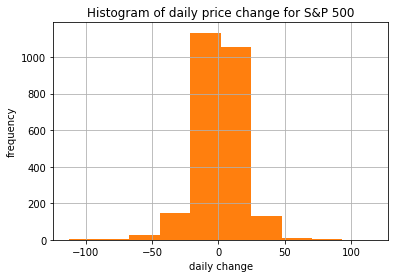

In [50]:
df.change.hist()
ax = df.change.hist()
ax.set(xlabel='daily change', ylabel='frequency', title='Histogram of daily price change for S&P 500')
plt.show()

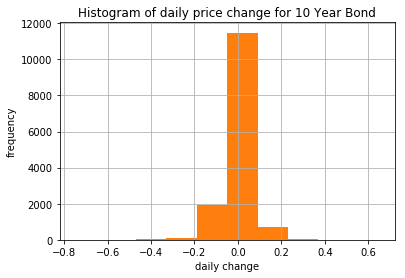

In [51]:
df_10.change.hist()
ax = df_10.change.hist()
ax.set(xlabel='daily change', ylabel='frequency', title='Histogram of daily price change for 10 Year Bond')
plt.show()

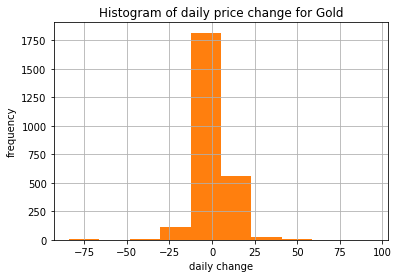

In [52]:
df_gold.change.hist()
ax = df_gold.change.hist()
ax.set(xlabel='daily change', ylabel='frequency', title='Histogram of daily price change for Gold')
plt.show()

Looks like the daily change values are close to normally distributed for each security, so we can continue and check the statistical significance of the values for each day of the week.

In [53]:
df.shape

(2516, 15)

In [54]:
# For S&P 500
print(df.loc[df['weekday'] == 0, 'change'].sum())
print(df.loc[df['weekday'] == 1, 'change'].sum())
print(df.loc[df['weekday'] == 2, 'change'].sum())
print(df.loc[df['weekday'] == 3, 'change'].sum())
print(df.loc[df['weekday'] == 4, 'change'].sum())

101.3599999999933
641.9000000000053
601.8699999999991
320.37999999999533
332.9700000000071


So, this means that on Mondays, the total change in the value of the S&P 500 index was about +100.  The total change on all Tuesdays was about +640.  The next step converts the changes to an average per trading day.

In [55]:
# For 10 Yr Bond
print(df_10.loc[df_10['weekday'] == 0, 'change'].sum())
print(df_10.loc[df_10['weekday'] == 1, 'change'].sum())
print(df_10.loc[df_10['weekday'] == 2, 'change'].sum())
print(df_10.loc[df_10['weekday'] == 3, 'change'].sum())
print(df_10.loc[df_10['weekday'] == 4, 'change'].sum())

13.210000000000022
-6.320000000000043
1.0500000000000325
-2.120000000000004
-7.880000000000006


In [56]:
# Average daily move for S&P 500
print(df.loc[df['weekday'] == 0, 'change'].sum()/2516)
print(df.loc[df['weekday'] == 1, 'change'].sum()/2516)
print(df.loc[df['weekday'] == 2, 'change'].sum()/2516)
print(df.loc[df['weekday'] == 3, 'change'].sum()/2516)
print(df.loc[df['weekday'] == 4, 'change'].sum()/2516)

0.04028616852145998
0.25512718600954104
0.23921701112877547
0.12733704292527637
0.1323410174880791


In [57]:
# Average daily move for 10 Yr Bond
print(df_10.loc[df_10['weekday'] == 0, 'change'].sum()/2516)
print(df_10.loc[df_10['weekday'] == 1, 'change'].sum()/2516)
print(df_10.loc[df_10['weekday'] == 2, 'change'].sum()/2516)
print(df_10.loc[df_10['weekday'] == 3, 'change'].sum()/2516)
print(df_10.loc[df_10['weekday'] == 4, 'change'].sum()/2516)

0.005250397456279818
-0.0025119236883942935
0.00041732909379969493
-0.0008426073131955501
-0.0031319554848966637


In [58]:
# For 10 Yr Bond (just last 10 years)
print(df_10_10.loc[df_10_10['weekday'] == 0, 'change'].sum())
print(df_10_10.loc[df_10_10['weekday'] == 1, 'change'].sum())
print(df_10_10.loc[df_10_10['weekday'] == 2, 'change'].sum())
print(df_10_10.loc[df_10_10['weekday'] == 3, 'change'].sum())
print(df_10_10.loc[df_10_10['weekday'] == 4, 'change'].sum())

-0.2999999999999974
-0.09999999999999942
1.7399999999999969
-0.8699999999999986
-1.9900000000000015


In [59]:
# For gold (just last 10 years)
print(df_gold.loc[df_gold['weekday'] == 0, 'change'].sum())
print(df_gold.loc[df_gold['weekday'] == 1, 'change'].sum())
print(df_gold.loc[df_gold['weekday'] == 2, 'change'].sum())
print(df_gold.loc[df_gold['weekday'] == 3, 'change'].sum())
print(df_gold.loc[df_gold['weekday'] == 4, 'change'].sum())

538.5429999999996
415.8369999999994
-40.4830000000004
-459.0160000000003
93.1730000000016


In [60]:
# For oil (just last 10 years)
print(df_oil.loc[df_oil['weekday'] == 0, 'change'].sum())
print(df_oil.loc[df_oil['weekday'] == 1, 'change'].sum())
print(df_oil.loc[df_oil['weekday'] == 2, 'change'].sum())
print(df_oil.loc[df_oil['weekday'] == 3, 'change'].sum())
print(df_oil.loc[df_oil['weekday'] == 4, 'change'].sum())

-21.540000000000035
31.520000000000003
23.049999999999805
-30.409999999999826
-13.029999999999951


In [61]:
# For bitcoin
print(df_btc.loc[df_btc['weekday'] == 0, 'change'].sum())
print(df_btc.loc[df_btc['weekday'] == 1, 'change'].sum())
print(df_btc.loc[df_btc['weekday'] == 2, 'change'].sum())
print(df_btc.loc[df_btc['weekday'] == 3, 'change'].sum())
print(df_btc.loc[df_btc['weekday'] == 4, 'change'].sum())
print(df_btc.loc[df_btc['weekday'] == 5, 'change'].sum())
print(df_btc.loc[df_btc['weekday'] == 6, 'change'].sum())

1421.7199999999955
978.4300000000011
-338.36000000000377
-1088.6800000000028
5006.700000000002
6821.430000000004
-853.5099999999965


### Are these numbers significant ??

In [62]:
# For S&P 500
df['Monday'] = df.change.where(df.weekday == 0)
df['Tuesday'] = df.change.where(df.weekday == 1)
df['Wednesday'] = df.change.where(df.weekday == 2)
df['Thursday'] = df.change.where(df.weekday == 3)
df['Friday'] = df.change.where(df.weekday == 4)

In [63]:
df.head()

,DATE,SP500,price,date_time,weekday,day,month,year,change,summer,winter,yr3s,yr3w,yr3w_2,yr3w_t,Monday,Tuesday,Wednesday,Thursday,Friday
DATE,,,,,,,,,,,,,,,,,,,,
2009-06-26,2009-06-26,918.90,918.90,2009-06-26,4,26,6,2009,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2009-06-29,2009-06-29,927.23,927.23,2009-06-29,0,29,6,2009,8.33,8.33,0.0,0.0,0.0,0.0,0.0,8.33,NaN,NaN,NaN,NaN
2009-06-30,2009-06-30,919.32,919.32,2009-06-30,1,30,6,2009,-7.91,-7.91,0.0,0.0,0.0,0.0,0.0,NaN,-7.91,NaN,NaN,NaN
2009-07-01,2009-07-01,923.33,923.33,2009-07-01,2,1,7,2009,4.01,4.01,0.0,0.0,0.0,0.0,0.0,NaN,NaN,4.01,NaN,NaN
2009-07-02,2009-07-02,896.42,896.42,2009-07-02,3,2,7,2009,-26.91,-26.91,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,-26.91,NaN


In [64]:
# For 10 Yr Bond
df_10['Monday'] = df_10.change.where(df_10.weekday == 0)
df_10['Tuesday'] = df_10.change.where(df_10.weekday == 1)
df_10['Wednesday'] = df_10.change.where(df_10.weekday == 2)
df_10['Thursday'] = df_10.change.where(df_10.weekday == 3)
df_10['Friday'] = df_10.change.where(df_10.weekday == 4)

In [65]:
df_10.head()

,DATE,DGS10,price,date_time,weekday,day,month,year,change,Monday,Tuesday,Wednesday,Thursday,Friday
DATE,,,,,,,,,,,,,,
1962-01-02,1962-01-02,4.06,4.06,1962-01-02,1,2,1,1962,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-03,1962-01-03,4.03,4.03,1962-01-03,2,3,1,1962,-0.03,NaN,NaN,-0.03,NaN,NaN
1962-01-04,1962-01-04,3.99,3.99,1962-01-04,3,4,1,1962,-0.04,NaN,NaN,NaN,-0.04,NaN
1962-01-05,1962-01-05,4.02,4.02,1962-01-05,4,5,1,1962,0.03,NaN,NaN,NaN,NaN,0.03
1962-01-08,1962-01-08,4.03,4.03,1962-01-08,0,8,1,1962,0.01,0.01,NaN,NaN,NaN,NaN


In [66]:
# For 10 Yr Bond (last 10 years)
df_10_10['Monday'] = df_10_10.change.where(df_10_10.weekday == 0)
df_10_10['Tuesday'] = df_10_10.change.where(df_10_10.weekday == 1)
df_10_10['Wednesday'] = df_10_10.change.where(df_10_10.weekday == 2)
df_10_10['Thursday'] = df_10_10.change.where(df_10_10.weekday == 3)
df_10_10['Friday'] = df_10_10.change.where(df_10_10.weekday == 4)

In [67]:
# For gold (last 10 years)
df_gold['Monday'] = df_gold.change.where(df_gold.weekday == 0)
df_gold['Tuesday'] = df_gold.change.where(df_gold.weekday == 1)
df_gold['Wednesday'] = df_gold.change.where(df_gold.weekday == 2)
df_gold['Thursday'] = df_gold.change.where(df_gold.weekday == 3)
df_gold['Friday'] = df_gold.change.where(df_gold.weekday == 4)

In [68]:
# For oil (last 10 years)
df_oil['Monday'] = df_oil.change.where(df_oil.weekday == 0)
df_oil['Tuesday'] = df_oil.change.where(df_oil.weekday == 1)
df_oil['Wednesday'] = df_oil.change.where(df_oil.weekday == 2)
df_oil['Thursday'] = df_oil.change.where(df_oil.weekday == 3)
df_oil['Friday'] = df_oil.change.where(df_oil.weekday == 4)

# For bitcoin
df_btc['Monday'] = df_btc.change.where(df_oil.weekday == 0)
df_btc['Tuesday'] = df_btc.change.where(df_oil.weekday == 1)
df_btc['Wednesday'] = df_btc.change.where(df_oil.weekday == 2)
df_btc['Thursday'] = df_btc.change.where(df_oil.weekday == 3)
df_btc['Friday'] = df_btc.change.where(df_oil.weekday == 4)
df_btc['Saturday'] = df_btc.change.where(df_oil.weekday == 5)
df_btc['Sunday'] = df_btc.change.where(df_oil.weekday == 6)

In [69]:
df_btc.head()

,DATE,CBBTCUSD,price,date_time,weekday,day,month,year,change,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,2014-12-01,370,370.0,2014-12-01,0,1,12,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-12-02,378,378.0,2014-12-02,1,2,12,2014,8.0,NaN,NaN,NaN,8.0,NaN,NaN,NaN
2,2014-12-03,378,378.0,2014-12-03,2,3,12,2014,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,2014-12-04,377.1,377.1,2014-12-04,3,4,12,2014,-0.9,-0.9,NaN,NaN,NaN,NaN,NaN,NaN
5,2014-12-06,378,378.0,2014-12-06,5,6,12,2014,0.9,NaN,NaN,0.9,NaN,NaN,NaN,NaN


In [70]:
df_btc = df_btc.fillna(0)

In [71]:
# For S&P 500 grouped by month

df['Jan'] = df.change.where(df.month == 1)
df['Feb'] = df.change.where(df.month == 2)
df['Mar'] = df.change.where(df.month == 3)
df['Apr'] = df.change.where(df.month == 4)
df['May'] = df.change.where(df.month == 5)
df['June'] = df.change.where(df.month == 6)
df['July'] = df.change.where(df.month == 7)
df['Aug'] = df.change.where(df.month == 8)
df['Sep'] = df.change.where(df.month == 9)
df['Oct'] = df.change.where(df.month == 10)
df['Nov'] = df.change.where(df.month == 11)
df['Dec'] = df.change.where(df.month == 12)


In [72]:
df.head(20)

,DATE,SP500,price,date_time,weekday,day,month,year,change,summer,...,Mar,Apr,May,June,July,Aug,Sep,Oct,Nov,Dec
DATE,,,,,,,,,,,,,,,,,,,,,
2009-06-26,2009-06-26,918.90,918.90,2009-06-26,4,26,6,2009,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-06-29,2009-06-29,927.23,927.23,2009-06-29,0,29,6,2009,8.33,8.33,...,NaN,NaN,NaN,8.33,NaN,NaN,NaN,NaN,NaN,NaN
2009-06-30,2009-06-30,919.32,919.32,2009-06-30,1,30,6,2009,-7.91,-7.91,...,NaN,NaN,NaN,-7.91,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,2009-07-01,923.33,923.33,2009-07-01,2,1,7,2009,4.01,4.01,...,NaN,NaN,NaN,NaN,4.01,NaN,NaN,NaN,NaN,NaN
2009-07-02,2009-07-02,896.42,896.42,2009-07-02,3,2,7,2009,-26.91,-26.91,...,NaN,NaN,NaN,NaN,-26.91,NaN,NaN,NaN,NaN,NaN
2009-07-06,2009-07-06,898.72,898.72,2009-07-06,0,6,7,2009,2.30,2.30,...,NaN,NaN,NaN,NaN,2.30,NaN,NaN,NaN,NaN,NaN
2009-07-07,2009-07-07,881.03,881.03,2009-07-07,1,7,7,2009,-17.69,-17.69,...,NaN,NaN,NaN,NaN,-17.69,NaN,NaN,NaN,NaN,NaN
2009-07-08,2009-07-08,879.56,879.56,2009-07-08,2,8,7,2009,-1.47,-1.47,...,NaN,NaN,NaN,NaN,-1.47,NaN,NaN,NaN,NaN,NaN
2009-07-09,2009-07-09,882.68,882.68,2009-07-09,3,9,7,2009,3.12,3.12,...,NaN,NaN,NaN,NaN,3.12,NaN,NaN,NaN,NaN,NaN


### t-test and p-values

In [73]:
# For S&P 500
ttest_ind(df['Monday'].dropna(), df['Tuesday'].dropna())

Ttest_indResult(statistic=-0.9729604233090785, pvalue=0.3308115971409148)

The pvalue is greater than .05.  Therefore, the difference in price from Monday and Tuesday, which are the two most extreme prices in the data, is not significant.  In other words the difference here is probably just due to chance and the values are taken from the same population.

In [74]:
# For 10 Yr Bond
ttest_ind(df_10['Monday'].dropna(), df_10['Friday'].dropna())

Ttest_indResult(statistic=4.070425782579718, pvalue=4.757789969930339e-05)

The pvalue is here is much less than .05.  Therefore, the difference in price from Monday and Friday, which are the two most extreme price changes in the data, is significant.  In other words the difference here is probably NOT just due to chance and the values are taken from the DIFFERENT populations.

In [75]:
# For 10 Yr Bond (last 10 years only)
ttest_ind(df_10_10['Wednesday'].dropna(), df_10_10['Friday'].dropna())

Ttest_indResult(statistic=2.2201929261497884, pvalue=0.026625706685281653)

In [76]:
# For gold (last 10 years only)
ttest_ind(df_gold['Monday'].dropna(), df_gold['Thursday'].dropna())

Ttest_indResult(statistic=3.3440189329939844, pvalue=0.0008567701430384474)

A null hypothesis is a hypothesis that says there is no statistical significance between the two variables in the hypothesis.  In the case of gold, since the pvalue is less than 0.05, the null hypotheses cannot be rejected and it would be likely that the two variables indeed have a statistically significant difference.

In [77]:
# For oil (last 10 years only)
ttest_ind(df_oil['Tuesday'].dropna(), df_oil['Thursday'].dropna())

Ttest_indResult(statistic=1.371972242519745, pvalue=0.17037285733436644)

In [78]:
# For bitcoin
ttest_ind(df_btc['Thursday'].dropna(), df_btc['Saturday'].dropna())

Ttest_indResult(statistic=2.3029987853710954, pvalue=0.02134134968122411)

For the case of bitcoin, there is an approximately **2.1%** probability that the difference in sums of Thursday vs. Saturday happened randomly.  Thursday was the lowest value, Saturday was the highest.

In [79]:
# For S&P 500 groupby month
ttest_ind(df['May'].dropna(), df['July'].dropna())

Ttest_indResult(statistic=-2.1657996427395316, pvalue=0.030885931123197312)

The above ttest does show that May is significantly weaker than July for the S&P 500 over the last 10 years.  The calculated pvalue is 0.03 which is less than 0.05, so the differences are likely to be real, rather than just due to chance.  This same process could be performed for all 5 securities to determine if any month or months behaved significantly different from one or more of the others. 

### F statistics

In [80]:
# Calc F statistic for S&P 500
F, p = stats.f_oneway(
    df['Monday'].dropna(),
    df['Tuesday'].dropna(),
    df['Wednesday'].dropna(),
    df['Thursday'].dropna(),
    df['Friday'].dropna(),
)

# The F statistic.
print(F)

# The probability. A p < .05 would lead us to believe the group means were
# not all similar in the population.
print(p)

0.31788075585528736
0.8661571754552783


It appears that the 5 groups (Monday, Tuesday, Wednesday, Thursday, Friday) are not likely to differ in the population (p = 0.886 which is greater than .05)

In [81]:
# Calc F statistic for 10 Yr Bond
F, p = stats.f_oneway(
    df_10['Monday'].dropna(),
    df_10['Tuesday'].dropna(),
    df_10['Wednesday'].dropna(),
    df_10['Thursday'].dropna(),
    df_10['Friday'].dropna(),
)

# The F statistic.
print(F)

# The probability. A p < .05 would lead us to believe the group means were
# not all similar in the population.
print(p)

5.955302563763542
8.74703589845011e-05


Here again, the p values is much less than .05 which means the data for each day are from different populations for at least 2 of the days.  In other words, the day of the week matters as it relates to price movement.  Mondays are more likely to incur a positive change in interest rate, whereas Tuesdays and Fridays are more likely to see a negative change.

In [82]:
# Calc F statistic for 10 Yr Bond (last 10 years only)
F, p = stats.f_oneway(
    df_10_10['Monday'].dropna(),
    df_10_10['Tuesday'].dropna(),
    df_10_10['Wednesday'].dropna(),
    df_10_10['Thursday'].dropna(),
    df_10_10['Friday'].dropna(),
)

# The F statistic.
print(F)

# The probability. A p < .05 would lead us to believe the group means were
# not all similar in the population.
print(p)

1.4622747373794742
0.2110585653345958


Not much to see here.  Looks like the difference in interest rate change from day to day the 10 Yr Bond over the last 10 years are simply due to random chance.

In [83]:
# Calc F statistic for gold (last 10 years only)
F, p = stats.f_oneway(
    df_gold['Monday'].dropna(),
    df_gold['Tuesday'].dropna(),
    df_gold['Wednesday'].dropna(),
    df_gold['Thursday'].dropna(),
    df_gold['Friday'].dropna(),
)

# The F statistic.
print(F)

# The probability. A p < .05 would lead us to believe the group means were
# not all similar in the population.
print(p)

3.8675627733544693
0.0038892555965370883


In [84]:
# Calc F statistic for oil (last 10 years only)
F, p = stats.f_oneway(
    df_oil['Monday'].dropna(),
    df_oil['Tuesday'].dropna(),
    df_oil['Wednesday'].dropna(),
    df_oil['Thursday'].dropna(),
    df_oil['Friday'].dropna(),
)

# The F statistic.
print(F)

# The probability. A p < .05 would lead us to believe the group means were
# not all similar in the population.
print(p)

0.7994683577387657
0.525397715297364


In [85]:
# Calc F statistic for bitcoin
F, p = stats.f_oneway(
    df_btc['Monday'].dropna(),
    df_btc['Tuesday'].dropna(),
    df_btc['Wednesday'].dropna(),
    df_btc['Thursday'].dropna(),
    df_btc['Friday'].dropna(),
    df_btc['Saturday'].dropna(),
    df_btc['Sunday'].dropna(),
)

# The F statistic.
print(F)

# The probability. A p < .05 would lead us to believe the group means were
# not all similar in the population.
print(p)

1.546179669499771
0.15869572325805537


In [86]:
# Calc F statistic for S&P 500 grouped by month
F, p = stats.f_oneway(
    df['Jan'].dropna(),
    df['Feb'].dropna(),
    df['Mar'].dropna(),
    df['Apr'].dropna(),
    df['May'].dropna(),
    df['June'].dropna(),
    df['July'].dropna(),
    df['Aug'].dropna(),
    df['Sep'].dropna(),
    df['Oct'].dropna(),
    df['Nov'].dropna(),
    df['Dec'].dropna(),
)

# The F statistic.
print(F)

# The probability. A p < .05 would lead us to believe the group means were
# not all similar in the population.
print(p)

0.6825850026550205
0.7563506335281399


A high F value means that your data does not well support your null hypothesis. ... So a large F value indicates that a linear model is more compatible with the data than a constant average model. These predictors have high F values leading to small p values so they are sufficient for predicting the response.  

A null hypothesis is a hypothesis that says there is no statistical significance between the two variables in the hypothesis.  In the case of bitcoin, there is a roughly 16% probability that the different sums for the day of the week could have happened due to chance.  

(maybe implement sell in May and go away for year 3 in Presidential term vs. years 1, 2, 4.)

### Prepare the S&P 500 data for building a Supervised Learning model to predict the price change.

In [87]:
df['change'].fillna(0, inplace=True)

In [88]:
df.head()

,DATE,SP500,price,date_time,weekday,day,month,year,change,summer,...,Mar,Apr,May,June,July,Aug,Sep,Oct,Nov,Dec
DATE,,,,,,,,,,,,,,,,,,,,,
2009-06-26,2009-06-26,918.90,918.90,2009-06-26,4,26,6,2009,0.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-06-29,2009-06-29,927.23,927.23,2009-06-29,0,29,6,2009,8.33,8.33,...,NaN,NaN,NaN,8.33,NaN,NaN,NaN,NaN,NaN,NaN
2009-06-30,2009-06-30,919.32,919.32,2009-06-30,1,30,6,2009,-7.91,-7.91,...,NaN,NaN,NaN,-7.91,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,2009-07-01,923.33,923.33,2009-07-01,2,1,7,2009,4.01,4.01,...,NaN,NaN,NaN,NaN,4.01,NaN,NaN,NaN,NaN,NaN
2009-07-02,2009-07-02,896.42,896.42,2009-07-02,3,2,7,2009,-26.91,-26.91,...,NaN,NaN,NaN,NaN,-26.91,NaN,NaN,NaN,NaN,NaN


In [89]:
df.drop(['DATE'], axis=1, inplace=True)
df.drop(['SP500'], axis=1, inplace=True)
df.drop(['price'], axis=1, inplace=True)
df.drop(['date_time'], axis=1, inplace=True)
df.drop(['year'], axis=1, inplace=True)
df.drop(['Monday'], axis=1, inplace=True)
df.drop(['Tuesday'], axis=1, inplace=True)
df.drop(['Wednesday'], axis=1, inplace=True)
df.drop(['Thursday'], axis=1, inplace=True)
df.drop(['Friday'], axis=1, inplace=True)
df.drop(['Jan'], axis=1, inplace=True)
df.drop(['Feb'], axis=1, inplace=True)
df.drop(['Mar'], axis=1, inplace=True)
df.drop(['Apr'], axis=1, inplace=True)
df.drop(['May'], axis=1, inplace=True)
df.drop(['June'], axis=1, inplace=True)
df.drop(['July'], axis=1, inplace=True)
df.drop(['Aug'], axis=1, inplace=True)
df.drop(['Sep'], axis=1, inplace=True)
df.drop(['Oct'], axis=1, inplace=True)
df.drop(['Nov'], axis=1, inplace=True)
df.drop(['Dec'], axis=1, inplace=True)
df.drop(['summer'], axis=1, inplace=True)
df.drop(['winter'], axis=1, inplace=True)
df.drop(['yr3s'], axis=1, inplace=True)
df.drop(['yr3w'], axis=1, inplace=True)
df.drop(['yr3w_2'], axis=1, inplace=True)
df.drop(['yr3w_t'], axis=1, inplace=True)

In [90]:
df.head()

,weekday,day,month,change
DATE,,,,
2009-06-26,4,26,6,0.00
2009-06-29,0,29,6,8.33
2009-06-30,1,30,6,-7.91
2009-07-01,2,1,7,4.01
2009-07-02,3,2,7,-26.91


In [91]:
df.dtypes

weekday      int64
day          int64
month        int64
change     float64
dtype: object

### Build the S&P 500 model - Linear Regression

In [92]:
# Create training and test sets.
offset = int(df.shape[0] * 0.8)

df_train = df[:offset]
df_test = df[offset:]

In [93]:
print(df_train.shape)
print(df_test.shape)

(2012, 4)
(504, 4)


In [94]:
# 1.  Linear Regression

from datetime import datetime
start_time = datetime.now()

# Instantiate our model.
regr = linear_model.LinearRegression()

# set features and dependent variable for training data
y_train = df_train['change'].values

# drop the 'change' column to obtain the feature inputs
df_train.drop(['change'], axis=1, inplace=True)

# normalize the training data
x_train = sklearn.preprocessing.normalize(df_train)

# now for test...
y_test = df_test['change'].values

# drop the 'change' column to obtain the feature inputs
df_test.drop(['change'], axis=1, inplace=True)

# normalize the test data
x_test = sklearn.preprocessing.normalize(df_test)

# fit model to training data
regr.fit(x_train, y_train)

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Duration: 0:00:00.140008


C:\Users\Fred\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\Fred\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [95]:
# Display the attributes we calculated.
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
print('\nR-squared train:')
print(regr.score(x_train, y_train))

print('\nR-squared test:')
print(regr.score(x_test, y_test))

Coefficients: 
 [ 0.86900286 -0.88945947 -0.19400148]
Intercept: 
 1.4380390819510813

R-squared train:
0.00025570067855062995

R-squared test:
3.3742136453129845e-05


### Prepare the 10 Yr Bond data for building a Supervised Learning model to predict the price change.

In [96]:
df_10.head()

,DATE,DGS10,price,date_time,weekday,day,month,year,change,Monday,Tuesday,Wednesday,Thursday,Friday
DATE,,,,,,,,,,,,,,
1962-01-02,1962-01-02,4.06,4.06,1962-01-02,1,2,1,1962,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-03,1962-01-03,4.03,4.03,1962-01-03,2,3,1,1962,-0.03,NaN,NaN,-0.03,NaN,NaN
1962-01-04,1962-01-04,3.99,3.99,1962-01-04,3,4,1,1962,-0.04,NaN,NaN,NaN,-0.04,NaN
1962-01-05,1962-01-05,4.02,4.02,1962-01-05,4,5,1,1962,0.03,NaN,NaN,NaN,NaN,0.03
1962-01-08,1962-01-08,4.03,4.03,1962-01-08,0,8,1,1962,0.01,0.01,NaN,NaN,NaN,NaN


In [97]:
df_10['change'].fillna(0, inplace=True)

df_10.drop(['DATE'], axis=1, inplace=True)
df_10.drop(['DGS10'], axis=1, inplace=True)
df_10.drop(['price'], axis=1, inplace=True)
df_10.drop(['date_time'], axis=1, inplace=True)
df_10.drop(['year'], axis=1, inplace=True)
df_10.drop(['Monday'], axis=1, inplace=True)
df_10.drop(['Tuesday'], axis=1, inplace=True)
df_10.drop(['Wednesday'], axis=1, inplace=True)
df_10.drop(['Thursday'], axis=1, inplace=True)
df_10.drop(['Friday'], axis=1, inplace=True)
df_10.drop(['day'], axis=1, inplace=True)
df_10.drop(['month'], axis=1, inplace=True)

In [98]:
df_10.head()

,weekday,change
DATE,,
1962-01-02,1,0.00
1962-01-03,2,-0.03
1962-01-04,3,-0.04
1962-01-05,4,0.03
1962-01-08,0,0.01


### Build the 10 Yr Bond model - Linear Regression

In [99]:
# Create training and test sets.
offset_10 = int(df_10.shape[0] * 0.8)

df_train_10 = df_10[:offset_10]
df_test_10 = df_10[offset_10:]

In [100]:
print(df_train_10.shape)
print(df_test_10.shape)

(11484, 2)
(2871, 2)


In [101]:
# 1.  Linear Regression

from datetime import datetime
start_time = datetime.now()

# Instantiate our model.
regr_10 = linear_model.LinearRegression()

# set features and dependent variable for training data
y_train_10 = df_train_10['change'].values

# drop the 'target' column to obtain the feature inputs
df_train_10.drop(['change'], axis=1, inplace=True)

# normalize the training data
x_train_10 = sklearn.preprocessing.normalize(df_train_10)

# now for test...
y_test_10 = df_test_10['change'].values

# drop the 'target' column to obtain the feature inputs
df_test_10.drop(['change'], axis=1, inplace=True)

# normalize the test data
x_test_10 = sklearn.preprocessing.normalize(df_test_10)

# fit model to training data
regr_10.fit(x_train_10, y_train_10)

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Duration: 0:00:00.126008


C:\Users\Fred\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\Fred\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [102]:
# Display the attributes we calculated.
print('Coefficients: \n', regr_10.coef_)
print('Intercept: \n', regr_10.intercept_)
print('\nR-squared train:')
print(regr_10.score(x_train_10, y_train_10))

print('\nR-squared test:')
print(regr_10.score(x_test_10, y_test_10))

Coefficients: 
 [-0.00833982]
Intercept: 
 0.006767582673497627

R-squared train:
0.002331639446182532

R-squared test:
-0.005007757394746459


R-squared value is fairly low here.  It did improve from .00081 to .0023 when the day of month and month were dropped from the data.  

The final model to test is for Gold since it had the lowest pvalue for the strongest day of the week vs. the weakest.  Maybe a predictive model such as Linear Regression or Random Forest will show some promise.  

### Prepare Gold data for building a Supervised Learning model to predict the price change.

In [103]:
df_gold.head()

,DATE,GOLDAMGBD229NLBM,price,date_time,weekday,day,month,year,change,Monday,Tuesday,Wednesday,Thursday,Friday
0,2009-06-26,572.566,572.566,2009-06-26,4,26,6,2009,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-06-29,570.133,570.133,2009-06-29,0,29,6,2009,-2.433,-2.433,NaN,NaN,NaN,NaN
2,2009-06-30,566.697,566.697,2009-06-30,1,30,6,2009,-3.436,NaN,-3.436,NaN,NaN,NaN
3,2009-07-01,567.296,567.296,2009-07-01,2,1,7,2009,0.599,NaN,NaN,0.599,NaN,NaN
4,2009-07-02,571.708,571.708,2009-07-02,3,2,7,2009,4.412,NaN,NaN,NaN,4.412,NaN


In [104]:
# make a copy of this dataframe for later:
df_gold_barplot = df_gold.copy()

In [105]:
df_gold['change'].fillna(0, inplace=True)

df_gold.drop(['DATE'], axis=1, inplace=True)
df_gold.drop(['GOLDAMGBD229NLBM'], axis=1, inplace=True)
df_gold.drop(['price'], axis=1, inplace=True)
df_gold.drop(['date_time'], axis=1, inplace=True)
df_gold.drop(['year'], axis=1, inplace=True)
df_gold.drop(['Monday'], axis=1, inplace=True)
df_gold.drop(['Tuesday'], axis=1, inplace=True)
df_gold.drop(['Wednesday'], axis=1, inplace=True)
df_gold.drop(['Thursday'], axis=1, inplace=True)
df_gold.drop(['Friday'], axis=1, inplace=True)
df_gold.drop(['day'], axis=1, inplace=True)
df_gold.drop(['month'], axis=1, inplace=True)

In [106]:
# make a copy of this dataframe for later:
df_bin = df_gold.copy()

In [107]:
df_gold.head()

,weekday,change
0,4,0.000
1,0,-2.433
2,1,-3.436
3,2,0.599
4,3,4.412


### Build the Gold model - Linear Regression

In [108]:
# Create training and test sets.
offset_gold = int(df_gold.shape[0] * 0.8)

df_train_gold = df_gold[:offset_gold]
df_test_gold = df_gold[offset_gold:]

In [109]:
print(df_train_gold.shape)
print(df_test_gold.shape)

(2020, 2)
(505, 2)


In [110]:
# 1.  Linear Regression

from datetime import datetime
start_time = datetime.now()

# Instantiate our model.
regr_gold = linear_model.LinearRegression()

# set features and dependent variable for training data
y_train_gold = df_train_gold['change'].values

# drop the 'target' column to obtain the feature inputs
df_train_gold.drop(['change'], axis=1, inplace=True)

# normalize the training data
x_train_gold = sklearn.preprocessing.normalize(df_train_gold)
# x_train_gold = df_train_gold

# now for test...
y_test_gold = df_test_gold['change'].values

# drop the 'target' column to obtain the feature inputs
df_test_gold.drop(['change'], axis=1, inplace=True)

# normalize the test data
x_test_gold = sklearn.preprocessing.normalize(df_test_gold)
# x_test_gold = df_test_gold

# fit model to training data
regr_gold.fit(x_train_gold, y_train_gold)

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Duration: 0:00:00.129008


C:\Users\Fred\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\Fred\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [111]:
# Display the attributes calculated.
print('Coefficients: \n', regr_gold.coef_)
print('Intercept: \n', regr_gold.intercept_)
print('\nR-squared train:')
print(regr_gold.score(x_train_gold, y_train_gold))

print('\nR-squared test:')
print(regr_gold.score(x_test_gold, y_test_gold))

Coefficients: 
 [-1.6376418]
Intercept: 
 1.5375145888594113

R-squared train:
0.004379886670989763

R-squared test:
-0.022705603892639648


In [112]:
df_gold.dtypes

weekday      int64
change     float64
dtype: object

### Random Forest

In [113]:
# 2.  Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor

# Instantiate our model.
rfc_gold = RandomForestRegressor(n_estimators=5000)

# fit model to data
rfc_gold.fit(x_train_gold, y_train_gold)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=5000, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [114]:
# Display the attributes calculated.

print('\nR-squared train:')
print(rfc_gold.score(x_train_gold, y_train_gold))

print('\nR-squared test:')
print(rfc_gold.score(x_test_gold, y_test_gold))


R-squared train:
0.00437977072393636

R-squared test:
-0.022533587339683914


### Gradient Boosting

In [115]:
# 3.  Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

# Instantiate our model.
gbr_gold = GradientBoostingRegressor(n_estimators=500)

# fit model to data
gbr_gold.fit(x_train_gold, y_train_gold)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [116]:
# Display the attributes calculated.

print('\nR-squared train:')
print(gbr_gold.score(x_train_gold, y_train_gold))

print('\nR-squared test:')
print(gbr_gold.score(x_test_gold, y_test_gold))


R-squared train:
0.004379886670989763

R-squared test:
-0.022705603892639648


Not very impressive results !  These 3 models are showing a very poor predictive value for daily price change given the day of the week.  Strange, since the ttest showed a significant difference.  To further investigate, a barplot is displayed next:

C:\Users\Fred\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


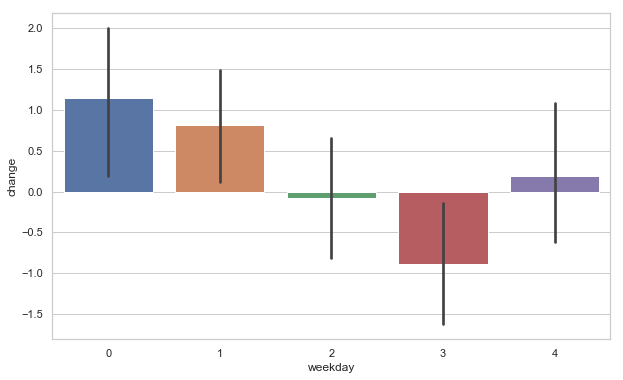

In [117]:
sns.set(style="whitegrid", rc={'figure.figsize':(10, 6)})
plt.xlabel('Day of Week')
plt.ylabel('Daily Price Change')
sns.barplot(x='weekday', y='change', ci=95, data=df_gold_barplot)
plt.show()

This clearly shows a difference in the day of the week for Mondays and Thursdays at the very least.  With a 95% level of confidence, this shows that the mean range (which is the average daily change over the entire 10 years) of Monday or Tuesday does not even overlap with the mean range on Thursday.  This is illustrated by the vertical black line for each day of the week above.  

Maybe converting the regression models to classification will improve the accuracy.  Instead of trying to predict the specific price movement, another option would be to try to predict if the price change will be positive or negative.  Next, the change price is converted to a 1 or 0, for an increase or decrease in price, respectively.

In [118]:
# convert to binary
df_bin['binary'] = np.where(df_bin.change > 0, 1, 0)

In [119]:
df_bin.head()

,weekday,change,binary
0,4,0.000,0
1,0,-2.433,0
2,1,-3.436,0
3,2,0.599,1
4,3,4.412,1


### Logistic Regression

In [120]:
# drop 'change' column
df_bin.drop(['change'], axis=1, inplace=True)

# Create training and test sets.
offset_bin = int(df_bin.shape[0] * 0.8)

df_train_bin = df_bin[:offset_bin]
df_test_bin = df_bin[offset_bin:]

print(df_train_bin.shape)
print(df_test_bin.shape)

(2020, 2)
(505, 2)


In [121]:
# 1.  Linear Regression

from datetime import datetime
start_time = datetime.now()

# Instantiate our model.
regr_bin = linear_model.LogisticRegression()

# set features and dependent variable for training data
y_train_bin = df_train_bin['binary'].values

# drop the 'binary' column to obtain the feature inputs
df_train_bin.drop(['binary'], axis=1, inplace=True)

# normalize the training data
x_train_bin = sklearn.preprocessing.normalize(df_train_bin)

# now for test...
y_test_bin = df_test_bin['binary'].values

# drop the 'binary' column to obtain the feature inputs
df_test_bin.drop(['binary'], axis=1, inplace=True)

# normalize the test data
x_test_bin = sklearn.preprocessing.normalize(df_test_bin)

# fit model to training data
regr_bin.fit(x_train_bin, y_train_bin)

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Duration: 0:00:00.134007


C:\Users\Fred\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\Fred\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\Fred\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [122]:
# Display the attributes calculated.
print('Coefficients: \n', regr_bin.coef_)
print('Intercept: \n', regr_bin.intercept_)
print('\nR-squared train:')
print(regr_bin.score(x_train_bin, y_train_bin))

print('\nR-squared test:')
print(regr_bin.score(x_test_bin, y_test_bin))

Coefficients: 
 [[-0.42538643]]
Intercept: 
 [0.33994285]

R-squared train:
0.5336633663366337

R-squared test:
0.4871287128712871


### Random Forest Classifier

In [123]:
# 2.  Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

# Instantiate our model.
rfc_bin = RandomForestClassifier(n_estimators=500)

# fit model to data
rfc_bin.fit(x_train_bin, y_train_bin)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [124]:
# Display the attributes calculated.

print('\nR-squared train:')
print(rfc_bin.score(x_train_bin, y_train_bin))

print('\nR-squared test:')
print(rfc_bin.score(x_test_bin, y_test_bin))


R-squared train:
0.5336633663366337

R-squared test:
0.4871287128712871


### Gradient Boosting Classifier

In [125]:
# 3.  Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingClassifier

# Instantiate our model.
gbc_bin = GradientBoostingClassifier(n_estimators=500)

# fit model to data
gbc_bin.fit(x_train_bin, y_train_bin)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [126]:
# Display the attributes calculated.

print('\nR-squared train:')
print(gbc_bin.score(x_train_bin, y_train_bin))

print('\nR-squared test:')
print(gbc_bin.score(x_test_bin, y_test_bin))


R-squared train:
0.5336633663366337

R-squared test:
0.4871287128712871


Looks like converting the model to binary did not help the predictive accuracy at all.  The ground truth is 0.50 and the score for test data is less than that.  From these models, the day of the week does not appear to have any predictive value.  

Next, create 5 new columns for Monday through Friday and set each column equal to 1 if it represents that day or 0 otherwise to see if this helps the predictive accuracy.

In [127]:
# check the data types for the gold binary dataframe
df_bin.dtypes

weekday    int64
binary     int32
dtype: object

In [128]:
df_bin.head()

,weekday,binary
0,4,0
1,0,0
2,1,0
3,2,1
4,3,1


In [129]:
df_bin['zero'] = np.where(df_bin.weekday == 0, 1, 0)
df_bin['one'] = np.where(df_bin.weekday == 1, 1, 0)
df_bin['two'] = np.where(df_bin.weekday == 2, 1, 0)
df_bin['three'] = np.where(df_bin.weekday == 3, 1, 0)
df_bin['four'] = np.where(df_bin.weekday == 4, 1, 0)

df_bin.drop(['weekday'], axis=1, inplace=True)

In [130]:
df_bin.head()

,binary,zero,one,two,three,four
0,0,0,0,0,0,1
1,0,1,0,0,0,0
2,0,0,1,0,0,0
3,1,0,0,1,0,0
4,1,0,0,0,1,0


In [131]:
# Create training and test sets.
offset_bin = int(df_bin.shape[0] * 0.8)

df_train_bin = df_bin[:offset_bin]
df_test_bin = df_bin[offset_bin:]

print(df_train_bin.shape)
print(df_test_bin.shape)

(2020, 6)
(505, 6)


In [132]:
# 1.  Logistic Regression

from datetime import datetime
start_time = datetime.now()

# Instantiate our model.
regr_bin2 = linear_model.LogisticRegression()

# set features and dependent variable for training data
y_train_bin = df_train_bin['binary'].values

# drop the 'binary' column to obtain the feature inputs
df_train_bin.drop(['binary'], axis=1, inplace=True)

# normalize the training data
# x_train_bin = sklearn.preprocessing.normalize(df_train_bin)
x_train_bin = df_train_bin

# now for test...
y_test_bin = df_test_bin['binary'].values

# drop the 'binary' column to obtain the feature inputs
df_test_bin.drop(['binary'], axis=1, inplace=True)

# normalize the test data
# x_test_bin = sklearn.preprocessing.normalize(df_test_bin)
x_test_bin = df_test_bin

# fit model to training data
regr_bin2.fit(x_train_bin, y_train_bin)

end_time = datetime.now()

C:\Users\Fred\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\Fred\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [133]:
# Display the attributes calculated.
print('Coefficients: \n', regr_bin2.coef_)
print('Intercept: \n', regr_bin2.intercept_)
print('\nR-squared train:')
print(regr_bin2.score(x_train_bin, y_train_bin))

print('\nR-squared test:')
print(regr_bin2.score(x_test_bin, y_test_bin))

Coefficients: 
 [[ 0.34449171  0.06264548 -0.01916885 -0.23071585 -0.15721648]]
Intercept: 
 [3.60017857e-05]

R-squared train:
0.5400990099009901

R-squared test:
0.48514851485148514


Still no evidence of any kind of predictive value for day of the week.

# 3.  Weather and Financial Data Combined

In [134]:
dfw.head()

,Sun
dt,
2009-06-25,0.00
2009-06-26,418.70
2009-06-27,743.23
2009-06-28,436.08
2009-06-29,848.28


In [135]:
dft.head()

,avg_temp
dt,
2009-06-25,71.72
2009-06-26,76.91
2009-06-27,76.34
2009-06-28,72.35
2009-06-29,75.43


Reset the index of this dataframe in order to merge this data with another dataframe.

In [136]:
# reset the index of this dataframe in order to merge this data with another dataframe
dfw.reset_index(level=0, inplace=True)
dft.reset_index(level=0, inplace=True)

Check to make sure the data is captured for the entire horizon for S&P 500:

In [137]:
df.tail()

,weekday,day,month,change
DATE,,,,
2019-06-19,2,19,6,8.71
2019-06-20,3,20,6,27.72
2019-06-21,4,21,6,-3.72
2019-06-24,0,24,6,-5.11
2019-06-25,1,25,6,-27.97


Print the columns of the data frame for S&P 500 and reset the index for merging data with weather data:

In [138]:
# print columns and reset index
print(df.columns)
df.reset_index(level=0, inplace=True)

Index(['weekday', 'day', 'month', 'change'], dtype='object')


In [139]:
df.tail()

,DATE,weekday,day,month,change
2511,2019-06-19,2,19,6,8.71
2512,2019-06-20,3,20,6,27.72
2513,2019-06-21,4,21,6,-3.72
2514,2019-06-24,0,24,6,-5.11
2515,2019-06-25,1,25,6,-27.97


Show the data types in the df dataframe:

In [140]:
df.dtypes

DATE       datetime64[ns]
weekday             int64
day                 int64
month               int64
change            float64
dtype: object

Finally, merge the weather data with the financial data for the S&P 500:

In [141]:
df_out = (dfw.merge(df, left_on='dt', right_on='DATE')
          .reindex(columns=['DATE', 'weekday', 'day', 'month', 'change', 'Sun']))

df_out_temp = (dft.merge(df, left_on='dt', right_on='DATE')
          .reindex(columns=['DATE', 'weekday', 'day', 'month', 'change', 'avg_temp']))

In [142]:
df_out_temp.head()

,DATE,weekday,day,month,change,avg_temp
0,2009-06-26,4,26,6,0.00,76.91
1,2009-06-29,0,29,6,8.33,75.43
2,2009-06-30,1,30,6,-7.91,77.41
3,2009-07-01,2,1,7,4.01,73.40
4,2009-07-02,3,2,7,-26.91,71.23


The above dataframe shows the merged S&P data with the temperature data.  Next, print the average of the average daily temps:

In [143]:
print(df_out_temp.avg_temp.mean())

55.04181240063589


In [144]:
df_out.head()

,DATE,weekday,day,month,change,Sun
0,2009-06-26,4,26,6,0.00,418.70
1,2009-06-29,0,29,6,8.33,848.28
2,2009-06-30,1,30,6,-7.91,608.00
3,2009-07-01,2,1,7,4.01,168.86
4,2009-07-02,3,2,7,-26.91,225.66


The above dataframe shows the "change" for the S&P 500 and the "Sun" for the number of hours of sunshine by date.

This next step counts the number of hours when the hours of **sunshine is greater than 300** and less than 300.  This cutoff of 300 is a good number because it has roughly the same amount of days above and below the threshold, keeping our data balanced.

In [145]:
# Creae 4 new columns in the df_out dataframe
df_out['sun_300'] = np.where(df_out.Sun >= 300.0, 1, 0)
df_out['less_300'] = np.where(df_out.Sun < 300.0, 1, 0)
df_out['value_3'] = np.where(df_out.Sun >= 300.0, df_out.change, 0)
df_out['value_3_less'] = np.where(df_out.Sun < 300.0, df_out.change, 0)

# Creae 4 new columns in the df_out_temp dataframe
df_out_temp['tmp_55'] = np.where(df_out_temp.avg_temp >= 55.0, 1, 0)
df_out_temp['less_55'] = np.where(df_out_temp.avg_temp < 55.0, 1, 0)
df_out_temp['value_55'] = np.where(df_out_temp.avg_temp >= 55.0, df_out_temp.avg_temp, 0)
df_out_temp['value_55_less'] = np.where(df_out_temp.avg_temp < 55.0, df_out_temp.avg_temp, 0)

In [146]:
df_out.head(10)

,DATE,weekday,day,month,change,Sun,sun_300,less_300,value_3,value_3_less
0,2009-06-26,4,26,6,0.00,418.70,1,0,0.00,0.00
1,2009-06-29,0,29,6,8.33,848.28,1,0,8.33,0.00
2,2009-06-30,1,30,6,-7.91,608.00,1,0,-7.91,0.00
3,2009-07-01,2,1,7,4.01,168.86,0,1,0.00,4.01
4,2009-07-02,3,2,7,-26.91,225.66,0,1,0.00,-26.91
5,2009-07-06,0,6,7,2.30,787.34,1,0,2.30,0.00
6,2009-07-07,1,7,7,-17.69,291.83,0,1,0.00,-17.69
7,2009-07-08,2,8,7,-1.47,636.53,1,0,-1.47,0.00
8,2009-07-09,3,9,7,3.12,639.93,1,0,3.12,0.00
9,2009-07-10,4,10,7,-3.55,895.12,1,0,-3.55,0.00


In [147]:
df_out_temp.head()

,DATE,weekday,day,month,change,avg_temp,tmp_55,less_55,value_55,value_55_less
0,2009-06-26,4,26,6,0.00,76.91,1,0,76.91,0.0
1,2009-06-29,0,29,6,8.33,75.43,1,0,75.43,0.0
2,2009-06-30,1,30,6,-7.91,77.41,1,0,77.41,0.0
3,2009-07-01,2,1,7,4.01,73.40,1,0,73.40,0.0
4,2009-07-02,3,2,7,-26.91,71.23,1,0,71.23,0.0


This next step defines some variables to count the number of days when the sunshine hours is above or below a specific threshold; and defines variables that counts the actual points gained or loss over the horizon for each of the two groups.

In [148]:
# FOR SUNSHINE
# count number of days where sunshine is at least 300 hours
a = df_out.sun_300.sum()

# count number of days where sunshine is less than 300 hours
a_less = df_out.less_300.sum()

# calculate the points gained when sunshine is at least 300 hours
b = np.where(df_out.Sun >= 300.0, df_out.change, 0).sum()

# calculate the points gained when sunshine is less than 300 hours
c = np.where(df_out.Sun < 300.0, df_out.change, 0).sum()

# FOR TEMPERATURE 
# count number of days where temp is at least 55 degrees F
at = df_out_temp.tmp_55.sum()

# count number of days where temp is less than 55
at_less = df_out_temp.less_55.sum()

# calculate the points gained when temp is at least 55
bt = np.where(df_out_temp.avg_temp >= 55.0, df_out_temp.change, 0).sum()

# calculate the points gained when temp is less than 55
ct = np.where(df_out_temp.avg_temp < 55.0, df_out_temp.change, 0).sum()

Print the results:

In [149]:
# FOR SUNSHINE
print('\nTotal number of days when sun hours is greater than 300:')
print(a)
print('\nTotal number of days when sun hours is less than 300:')
print(a_less)
print('\nTotal points gained in S&P 500 when number of sun hours is greater than 300:')
print(b)
print('\nTotal points gained in S&P 500 when number of sun hours is less than 300:')
print(c)

# FOR TEMPERATURE
print('\nTotal number of days when temperature is greater than or equal to 55:')
print(at)
print('\nTotal number of days when temp is less than 55:')
print(at_less)
print('\nTotal points gained in S&P 500 when temp is greater than 55:')
print(bt)
print('\nTotal points gained in S&P 500 when temp is less than 55:')
print(ct)


Total number of days when sun hours is greater than 300:
1295

Total number of days when sun hours is less than 300:
1221

Total points gained in S&P 500 when number of sun hours is greater than 300:
1159.2999999999988

Total points gained in S&P 500 when number of sun hours is less than 300:
839.1800000000013

Total number of days when temperature is greater than or equal to 55:
1314

Total number of days when temp is less than 55:
1202

Total points gained in S&P 500 when temp is greater than 55:
1038.2800000000007

Total points gained in S&P 500 when temp is less than 55:
960.1999999999994


Next, compare the average daily gain / loss of S&P 500 when sunshine hours is greater or less than 300 minutes per day.

In [150]:
# FOR SUNSHINE
print('\nAverage daily gain of S&P 500 when sun hours is greater than 300:')
print(b/a)

print('\nAverage daily gain of S&P 500 when sun hours is less than 300:')
print(c/a_less)

# FOR TEMPERATURE
print('\nAverage daily gain of S&P 500 when avg temperature is greater than 55:')
print(bt/at)

print('\nAverage daily gain of S&P 500 when avg temp is less than 55:')
print(ct/at_less)


Average daily gain of S&P 500 when sun hours is greater than 300:
0.8952123552123543

Average daily gain of S&P 500 when sun hours is less than 300:
0.6872891072891084

Average daily gain of S&P 500 when avg temperature is greater than 55:
0.7901674277016748

Average daily gain of S&P 500 when avg temp is less than 55:
0.7988352745424288


Is this difference signficant for the sunshine data ?  Remember that the overall average for all days over the 10 year period is **0.794** calculated earlier in this notebook.  

Obviously, the difference in average price gain / loss for the two different distributions is not significant.  The avg daily gain is **0.790** and **0.800** for days above 55 degrees F and below 55, respectively. 

Let's quickly try the differences for a 75 degree F vs 35 degree F cutoff:

In [151]:
# Creae 4 new columns in the df_out_temp dataframe
df_out_temp['tmp_75'] = np.where(df_out_temp.avg_temp > 75.0, 1, 0)
df_out_temp['tmp_35'] = np.where(df_out_temp.avg_temp < 35.0, 1, 0)
df_out_temp['value_75'] = np.where(df_out_temp.avg_temp > 75.0, df_out_temp.avg_temp, 0)
df_out_temp['value_35'] = np.where(df_out_temp.avg_temp < 35.0, df_out_temp.avg_temp, 0)
df_out_temp['change_75'] = np.where(df_out_temp.avg_temp > 75.0, df_out_temp.change, 0)
df_out_temp['change_35'] = np.where(df_out_temp.avg_temp < 35.0, df_out_temp.change, 0)

# drop unnecessary columns
df_out_temp.drop(['tmp_55'], axis=1, inplace=True)
df_out_temp.drop(['less_55'], axis=1, inplace=True)
df_out_temp.drop(['value_55'], axis=1, inplace=True)
df_out_temp.drop(['value_55_less'], axis=1, inplace=True)

In [152]:
df_out_temp.head()

,DATE,weekday,day,month,change,avg_temp,tmp_75,tmp_35,value_75,value_35,change_75,change_35
0,2009-06-26,4,26,6,0.00,76.91,1,0,76.91,0.0,0.00,0.0
1,2009-06-29,0,29,6,8.33,75.43,1,0,75.43,0.0,8.33,0.0
2,2009-06-30,1,30,6,-7.91,77.41,1,0,77.41,0.0,-7.91,0.0
3,2009-07-01,2,1,7,4.01,73.40,0,0,0.00,0.0,0.00,0.0
4,2009-07-02,3,2,7,-26.91,71.23,0,0,0.00,0.0,0.00,0.0


In [153]:
# FOR TEMPERATURE 
# count number of days where temp is at least 55 degrees F
a_75 = df_out_temp.tmp_75.sum()

# count number of days where temp is less than 55
a_35 = df_out_temp.tmp_35.sum()

# calculate the points gained when temp is at least 55
b_75 = np.where(df_out_temp.avg_temp > 75.0, df_out_temp.change, 0).sum()

# calculate the points gained when temp is less than 55
c_35 = np.where(df_out_temp.avg_temp < 35.0, df_out_temp.change, 0).sum()

In [154]:
df_out_temp.head()

,DATE,weekday,day,month,change,avg_temp,tmp_75,tmp_35,value_75,value_35,change_75,change_35
0,2009-06-26,4,26,6,0.00,76.91,1,0,76.91,0.0,0.00,0.0
1,2009-06-29,0,29,6,8.33,75.43,1,0,75.43,0.0,8.33,0.0
2,2009-06-30,1,30,6,-7.91,77.41,1,0,77.41,0.0,-7.91,0.0
3,2009-07-01,2,1,7,4.01,73.40,0,0,0.00,0.0,0.00,0.0
4,2009-07-02,3,2,7,-26.91,71.23,0,0,0.00,0.0,0.00,0.0


In [155]:
# FOR TEMPERATURE
print('\nTotal number of days when temperature is greater than 75:')
print(a_75)
print('\nTotal number of days when temp is less than 35:')
print(a_35)
print('\nTotal points gained in S&P 500 when temp is greater than 75:')
print(b_75)
print('\nTotal points gained in S&P 500 when temp is less than 35:')
print(c_35)


Total number of days when temperature is greater than 75:
364

Total number of days when temp is less than 35:
405

Total points gained in S&P 500 when temp is greater than 75:
-83.90999999999872

Total points gained in S&P 500 when temp is less than 35:
411.7500000000002


In [156]:
# FOR TEMPERATURE
print('\nAverage daily gain of S&P 500 when avg temperature is greater than 75:')
print(b_75/a_75)

print('\nAverage daily gain of S&P 500 when avg temp is less than 35:')
print(c_35/a_35)


Average daily gain of S&P 500 when avg temperature is greater than 75:
-0.2305219780219745

Average daily gain of S&P 500 when avg temp is less than 35:
1.0166666666666673


Is this significant ?  The next step is to compute the pvalue with a ttest:

In [157]:
# For temp greater than 75 vs less than 35
ttest_ind(df_out_temp['change_75'].dropna(), df_out_temp['change_35'].dropna())

Ttest_indResult(statistic=-1.0460206812846735, pvalue=0.29560174677866946)

Since the pvalue is **0.295**, the difference in daily price change values is not significant.  This calculation shows that there is about a 30% chance that the difference in the results were due to randam chance.

The next graph shows the visual relationship between the temperature and all of the daily change values.  From a quick scan, it looks like the returns above and below the 35 and 75 thresholds are fairly evenly distributed:  

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


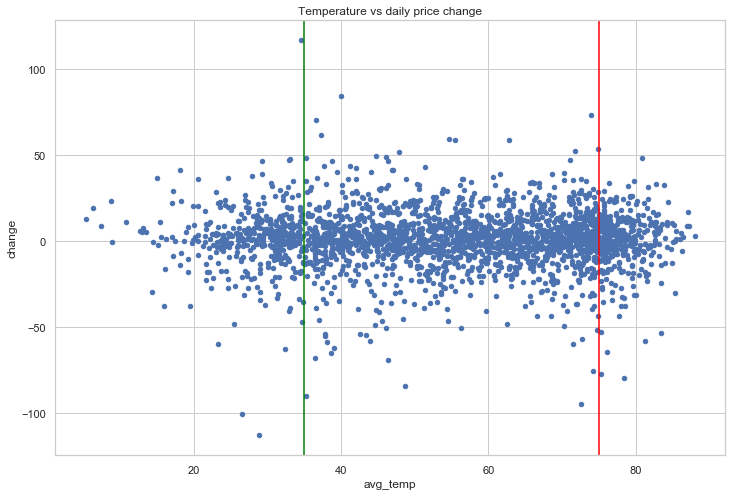

In [158]:
df_out_temp.plot(kind='scatter', x='avg_temp', y='change', title='Temperature vs daily price change', 
                 figsize=(12, 8), grid=True)
plt.axvline(x=35.0, color='green')
plt.axvline(x=75.0, color='red')

As stated above, this scatter plot shows a fairly even distibution of daily price change above and below the thresholds.

Now, compare the results using a **500 daily minutes** of sun cutoff.  This is the same process and code as above only using a cutoff value of 500 instead of 300.

In [159]:
df_out['sun_500'] = np.where(df_out.Sun >= 500.0, 1, 0)
df_out['less_500'] = np.where(df_out.Sun < 500.0, 1, 0)
df_out['value_5'] = np.where(df_out.Sun >= 500.0, df_out.change, 0)
df_out['value_5_less'] = np.where(df_out.Sun < 500.0, df_out.change, 0)

In [160]:
x = df_out.sun_500.sum()
x_less = df_out.less_500.sum()
y = np.where(df_out.Sun >= 500.0, df_out.change, 0).sum()
z = np.where(df_out.Sun < 500.0, df_out.change, 0).sum()

Print the results:

In [161]:
print('\nTotal number of days when sun hours is greater than 500:')
print(x)

print('\nTotal number of days when sun hours is less than 500:')
print(x_less)

print('\nTotal points gained in S&P 500 when number of sun hours is greater than 500:')
print(y)

print('\nTotal points gained in S&P 500 when number of sun hours is less than 500:')
print(z)


Total number of days when sun hours is greater than 500:
902

Total number of days when sun hours is less than 500:
1614

Total points gained in S&P 500 when number of sun hours is greater than 500:
589.170000000003

Total points gained in S&P 500 when number of sun hours is less than 500:
1409.3099999999972


Print the average daily gains of the two different groups.

In [162]:
print('\nAverage daily gain of S&P 500 when sun hours is greater than 500:')
print(y/x)

print('\nAverage daily gain of S&P 500 when sun hours is less than 500:')
print(z/x_less)


Average daily gain of S&P 500 when sun hours is greater than 500:
0.6531818181818215

Average daily gain of S&P 500 when sun hours is less than 500:
0.8731784386617083


Are these daily differences significant ?  This is strange: now the average is greater in the 'less than' group.

What about the days when the number of sunsine hours is greater or less **700** ?  This is the same process and code as above only using a cutoff value of 700 instead of 300 or 500.

In [163]:
df_out['sun_700'] = np.where(df_out.Sun >= 700.0, 1, 0)
df_out['less_700'] = np.where(df_out.Sun < 700.0, 1, 0)
df_out['value_7'] = np.where(df_out.Sun >= 700.0, df_out.change, 0)
df_out['value_7_less'] = np.where(df_out.Sun < 700.0, df_out.change, 0)

d = df_out.sun_700.sum()
d_less = df_out.less_700.sum()
e = np.where(df_out.Sun >= 700.0, df_out.change, 0).sum()
f = np.where(df_out.Sun < 700.0, df_out.change, 0).sum()

Print the results:

In [164]:
print('\nTotal number of days when sun hours is greater than 700:')
print(d)

print('\nTotal number of days when sun hours is less than 700:')
print(d_less)

print('\nTotal points gained in S&P 500 when number of sun hours is greater than 700:')
print(e)

print('\nTotal points gained in S&P 500 when number of sun hours is less than 700:')
print(f)


Total number of days when sun hours is greater than 700:
373

Total number of days when sun hours is less than 700:
2143

Total points gained in S&P 500 when number of sun hours is greater than 700:
211.11999999999966

Total points gained in S&P 500 when number of sun hours is less than 700:
1787.3600000000006


Print the average daily gains of the two different groups.

In [165]:
print('\nAverage daily gain of S&P 500 when sun hours is greater than 700:')
print(e/d)

print('\nAverage daily gain of S&P 500 when sun hours is less than 700:')
print(f/d_less)


Average daily gain of S&P 500 when sun hours is greater than 700:
0.566005361930294

Average daily gain of S&P 500 when sun hours is less than 700:
0.834045730284648


Are these daily averge differences significant ?  It seems odd that the daily average gain for days with more than 300 minutes is larger than those days with less than 300.  However, the reverse is true for days where the cutoff of sunshine hours is 500 and 700.  In other words, the average daily price where sunshine hours is more than 500 and 700, is less than the gain on days where there is less than 500 and 700 hours of sun, respectively.  What is going on here ?

In [166]:
df_out.head()

,DATE,weekday,day,month,change,Sun,sun_300,less_300,value_3,value_3_less,sun_500,less_500,value_5,value_5_less,sun_700,less_700,value_7,value_7_less
0,2009-06-26,4,26,6,0.00,418.70,1,0,0.00,0.00,0,1,0.00,0.00,0,1,0.00,0.00
1,2009-06-29,0,29,6,8.33,848.28,1,0,8.33,0.00,1,0,8.33,0.00,1,0,8.33,0.00
2,2009-06-30,1,30,6,-7.91,608.00,1,0,-7.91,0.00,1,0,-7.91,0.00,0,1,0.00,-7.91
3,2009-07-01,2,1,7,4.01,168.86,0,1,0.00,4.01,0,1,0.00,4.01,0,1,0.00,4.01
4,2009-07-02,3,2,7,-26.91,225.66,0,1,0.00,-26.91,0,1,0.00,-26.91,0,1,0.00,-26.91


In [167]:
# For sunshine more than 300 vs less than 300
ttest_ind(df_out['value_3'].dropna(), df_out['value_3_less'].dropna())

Ttest_indResult(statistic=0.3810877859627107, pvalue=0.7031542048478165)

In [168]:
# For sunshine more than 500 vs less than 500
ttest_ind(df_out['value_5'].dropna(), df_out['value_5_less'].dropna())

Ttest_indResult(statistic=-0.9764164785096374, pvalue=0.328905074534642)

In [169]:
# For sunshine more than 700 vs less than 700
ttest_ind(df_out['value_7'].dropna(), df_out['value_7_less'].dropna())

Ttest_indResult(statistic=-1.877069483932292, pvalue=0.06056640489040069)

From these Ttests, none of the differences are significant; all could have happened due to random chance.  However, for days more or less than 700 minutes of sun, the pvalue is just slightly above 0.05 (actual value = 0.061).  Remember, the average gain was higher where number of sunshine minutes was less than 700.  This could be due to the fact that the winter months in general perform better than the summer months.  This fact was established earlier in this notebook.  This is further evidence that maybe it is better to "sell in May and go away".  This assumes of course that there is more sunshine in the summer months than the winter months, which is true after looking at the seasonal sunshine plot at the beginning of this notebook.  Here again, summer is defined as May 1st to October 31st.  

Why would the summer months see worse returns ?  Maybe traders and wall street professionals take more vacation in the summer and therefore less active in the markets -- and less activity means less bullish or lower price increases.  Maybe people are less tempted with outside activities in general in the winter and focus more on the markets, thus are more active and more bullish.  When traders and investors are more active, many believe that this increases risk.  It follows that if risk increases, expected returns need to increase and generally exhibiting more risk means buying more stocks.  These are just guesses.  It does seem, however, that in general the winter months perform better than the summer months.  This temporary conclusion was not the hypothesis of this study, nor was it the objective to prove or disprove this claim.  

The following plot shows the relationship between amount of daily sunhine vs. daily price change.  This should help to further clarify whether a true difference exists.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


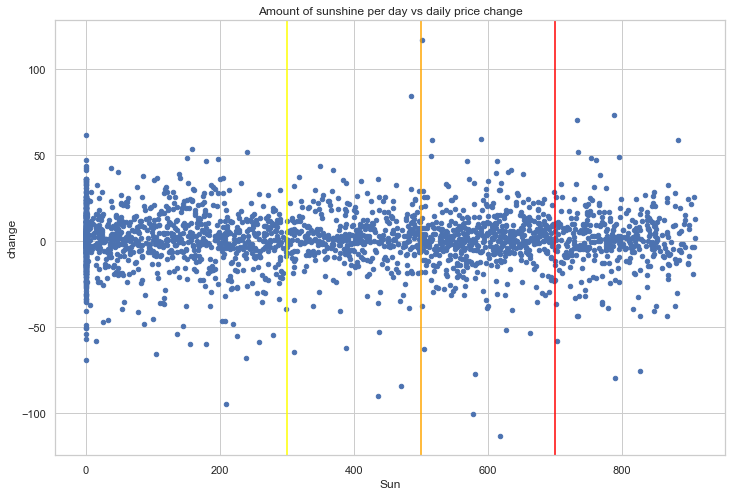

In [170]:
df_out.plot(kind='scatter', x='Sun', y='change', title='Amount of sunshine per day vs daily price change', 
                 figsize=(12, 8), grid=True)
plt.axvline(x=300, color='yellow')
plt.axvline(x=500, color='orange')
plt.axvline(x=700, color='red')

As the calculations and significance tests above show, it looks like there really is not asignificant correlation between the amount of daily sunshine in New York City and the price change of the S&P 500 over the last 10 years.  The winter (and thus less sunny) months might perform slightly better, but very difficult to see any evidence of that in the above scatter plot.  The safest conclusion and the conclusion best supported by the data is that there really is no signficant difference in daily returns regardless of the season or the amount of sunshine or the average daily temperature. 